In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
movie_reviews = pd.read_csv("/content/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:

movie_reviews["review"][3] #fourth row is print 

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

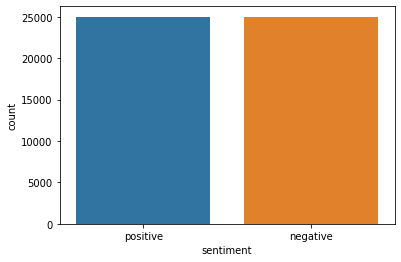

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [ ]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preparing the Embedding Layer


In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Glove Embedding

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Feed forward NN


In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           4627350   
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 1)                 5001      
                                                                 
Total params: 4,632,351
Trainable params: 5,001
Non-trainable params: 4,627,350
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
250/250 [==============================] - 1s 4ms/step - loss: 0.4812 - acc: 0.7703 - val_loss: 0.5870 - val_acc: 0.7150
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.4789 - acc: 0.7730 - val_loss: 0.5833 - val_acc: 0.7109
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.4792 - acc: 0.7725 - val_loss: 0.6062 - val_acc: 0.7039
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.4782 - acc: 0.7727 - val_loss: 0.5903 - val_acc: 0.7176
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.4797 - acc: 0.7720 - val_loss: 0.5865 - val_acc: 0.7145
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.4777 - acc: 0.7726 - val_loss: 0.5892 - val_acc: 0.7144
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.4765 - acc: 0.7742 - val_loss: 0.5940 - val_acc: 0.7124
Epoch 8/50
250/250 [==============================] - 1s 3ms/step - loss: 0.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.6136 - acc: 0.7074


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6135526299476624
Test Accuracy: 0.7074000239372253


## Text Classification with a Convolutional Neural Network(1DCNN)

In [ ]:
from keras.layers.convolutional import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           4627350   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,659,607
Trainable params: 32,257
Non-trainable params: 4,627,350
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.2) # training is done 

score = model.evaluate(X_test, y_test) #testing is done 

Epoch 1/50
250/250 [==============================] - 13s 49ms/step - loss: 0.5381 - acc: 0.7303 - val_loss: 0.4374 - val_acc: 0.8006
Epoch 2/50
250/250 [==============================] - 12s 49ms/step - loss: 0.4154 - acc: 0.8115 - val_loss: 0.4050 - val_acc: 0.8133
Epoch 3/50
250/250 [==============================] - 12s 49ms/step - loss: 0.3753 - acc: 0.8348 - val_loss: 0.3874 - val_acc: 0.8229
Epoch 4/50
250/250 [==============================] - 12s 49ms/step - loss: 0.3433 - acc: 0.8512 - val_loss: 0.3818 - val_acc: 0.8274
Epoch 5/50
250/250 [==============================] - 12s 48ms/step - loss: 0.3140 - acc: 0.8677 - val_loss: 0.3750 - val_acc: 0.8326
Epoch 6/50
250/250 [==============================] - 12s 49ms/step - loss: 0.2888 - acc: 0.8825 - val_loss: 0.3714 - val_acc: 0.8328
Epoch 7/50
250/250 [==============================] - 12s 49ms/step - loss: 0.2683 - acc: 0.8941 - val_loss: 0.3771 - val_acc: 0.8276
Epoch 8/50
250/250 [==============================] - 12s 49ms

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.8067252039909363
Test Accuracy: 0.8205000162124634


## Text Classification with Recurrent Neural Network (LSTM)

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 50)           4627350   
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,719,127
Trainable params: 91,777
Non-trainable params: 4,627,350
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/25
250/250 [==============================] - 84s 327ms/step - loss: 0.5917 - acc: 0.6823 - val_loss: 0.5272 - val_acc: 0.7320
Epoch 2/25
250/250 [==============================] - 82s 328ms/step - loss: 0.4876 - acc: 0.7658 - val_loss: 0.4543 - val_acc: 0.7856
Epoch 3/25
250/250 [==============================] - 82s 328ms/step - loss: 0.4471 - acc: 0.7922 - val_loss: 0.4212 - val_acc: 0.8067
Epoch 4/25
250/250 [==============================] - 81s 326ms/step - loss: 0.4211 - acc: 0.8091 - val_loss: 0.3934 - val_acc: 0.8240
Epoch 5/25
250/250 [==============================] - 82s 326ms/step - loss: 0.3967 - acc: 0.8190 - val_loss: 0.3932 - val_acc: 0.8199
Epoch 6/25
250/250 [==============================] - 82s 327ms/step - loss: 0.3781 - acc: 0.8312 - val_loss: 0.3826 - val_acc: 0.8296
Epoch 7/25
250/250 [==============================] - 82s 327ms/step - loss: 0.3618 - acc: 0.8404 - val_loss: 0.3673 - val_acc: 0.8339
Epoch 8/25
250/250 [==============================] - 8

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5906937718391418
Test Accuracy: 0.8266000151634216
